# Quick Example of Blind Source Separation
In this notebook, we will show you a quick example of blind source separation by Gauss-ILRMA.

In [18]:
!pip install ssspy

In [19]:
import numpy as np
import scipy.signal as ss
import IPython.display as ipd
import matplotlib.pyplot as plt

Here, we use sample music data.



In [20]:
import os
import urllib.request
from typing import Tuple

import ssspy

def download_sample_music_data(
    n_sources: int = 2,
    conv: bool = True,
    branch: str = "main"
) -> Tuple[np.ndarray, int]:
    instruments = ["violin", "piano"]
    root = ".data"
    url_template = "https://github.com/tky823/ssspy-data/raw/{branch}/{path}"
    path_template = "audio/{instrument}_8k_reverbed.wav"
    waveforms = []

    for src_idx in range(1, n_sources + 1):
        instrument = instruments[src_idx - 1]
        path = path_template.format(instrument=instrument)
        download_path = os.path.join(root, path)
        url = url_template.format(branch=branch, path=path)

        os.makedirs(os.path.dirname(download_path), exist_ok=True)

        if not os.path.exists(download_path):
            urllib.request.urlretrieve(url, download_path)

        waveform, sample_rate = ssspy.wavread(download_path, channels_first=True)

        assert sample_rate == 8000, f"Sampling rate is expected 8000, but {sample_rate} is given."

        waveforms.append(waveform)

    waveforms = np.stack(waveforms, axis=1)

    return waveforms[: n_sources], 8000

In [21]:
n_sources = 2
n_fft, hop_length = 2048, 512
window = "hann"

In [23]:
waveform_src_img, sample_rate = download_sample_music_data(
    n_sources=n_sources,
    conv=True,
)  # (n_channels, n_sources, n_samples)
print(waveform_src_img.shape)
waveform_mix = np.sum(waveform_src_img, axis=1)  # (n_channels, n_samples)
print(waveform_mix.shape)

(2, 2, 49279)
(2, 49279)


Let's listen to mixtures.

In [7]:
for idx, waveform in enumerate(waveform_mix):
    print("Mixture: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Mixture: 1


<IPython.lib.display.Audio object>


Mixture: 2


<IPython.lib.display.Audio object>

`ssspy.bss.ilrma.GaussILRMA` class provides Gauss-ILRMA.

In [8]:
from ssspy.bss.ilrma import GaussILRMA

In [9]:
ilrma = GaussILRMA(n_basis=3, rng=np.random.default_rng(0))
print(ilrma)

GaussILRMA(n_basis=3, spatial_algorithm=IP, source_algorithm=MM, domain=2, partitioning=False, normalization=True, scale_restoration=True, record_loss=True, reference_id=0)


In [10]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window=window, nperseg=n_fft, noverlap=n_fft-hop_length)

In [11]:
spectrogram_est = ilrma(spectrogram_mix, n_iter=500)

In [12]:
_, waveform_est = ss.istft(spectrogram_est, window=window, nperseg=n_fft, noverlap=n_fft-hop_length)

Let's listen to estimated sources.

In [13]:
for idx, waveform in enumerate(waveform_est):
    print("Estimated source: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Estimated source: 1


<IPython.lib.display.Audio object>


Estimated source: 2


<IPython.lib.display.Audio object>

Display cost at each iteration.

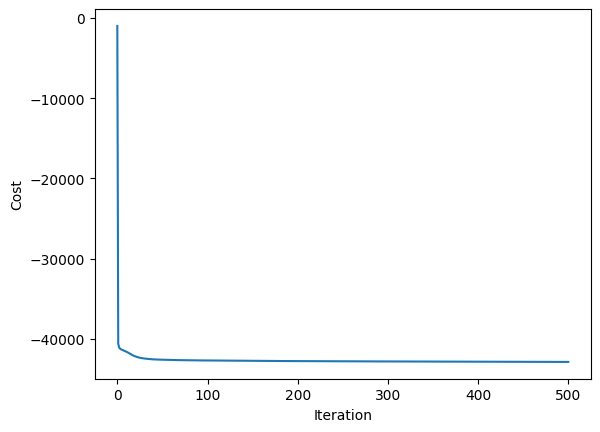

In [14]:
plt.figure()
plt.plot(range(len(ilrma.loss)), ilrma.loss)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
plt.close()

Since there has been a significant decrease by the first update, let's see the costs after the first iteration.

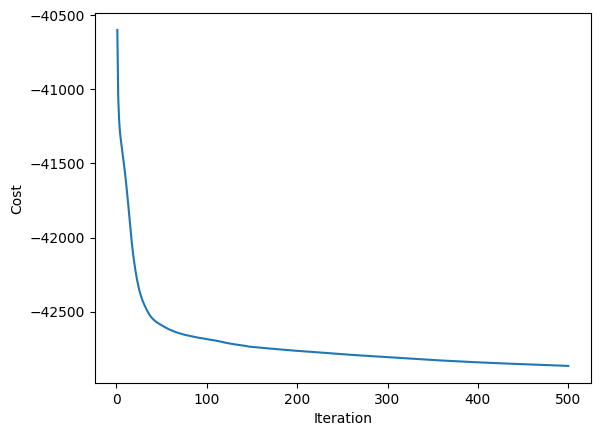

In [15]:
plt.figure()
plt.plot(range(1, len(ilrma.loss)), ilrma.loss[1:])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
plt.close()